In [ ]:
# import dependencies
# import sys
# !{sys.executable} -m pip install seaborn
import matplotlib as mplt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML
import geopy
from sklearn.cluster import KMeans

# display(HTML("<style>.container { width:85% !important; }</style>"))
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.set_option('display.max_columns', None)

pd.set_option('mode.chained_assignment', None)

RS = range(0,25,1)

print('currently running tensorflow version: ' + tf.__version__)

# ML Analysis

In [22]:
# select dataset to analyze

selected_dataset = 'df8'

if selected_dataset == 'df1':
    df1 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'n'
    )
    module = 'sm1'
    res = 'sr1'
    dataset = df1
    dataset.name = selected_dataset
if selected_dataset == 'df2':
    df2 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'off'
    )
    module = 'sm2'
    res = 'sr2'
    dataset = df2
    dataset.name = selected_dataset
if selected_dataset == 'df3':
    df3 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'on',
        anomaly_input = 1
    )
    module = 'sm3'
    res = 'sr3'
    dataset = df3
    dataset.name = selected_dataset
if selected_dataset == 'df4':
    df4 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'on',
        anomaly_input = 5
    )
    module = 'sm4'
    res = 'sr4'
    dataset = df4
    dataset.name = selected_dataset
if selected_dataset == 'df5':
    df5 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'off'
    )
    df5 = df5.drop('Zmed', axis = 1)
    dataset = df5
    dataset.name = selected_dataset
    module = 'sm5'
    res = 'sr5'
if selected_dataset == 'df6':
    df6 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'r',
        region_selection = 1,
        area_scrubber = 'off'
    )
    module = 'sm6'
    res = 'sr6'
    reg = df6['region'].iloc[-1]
    df6 = df6.drop('region', axis=1)
    dataset = df6 
    dataset.name = str('df6_' + str(reg))
if selected_dataset == 'df7':
    df7 = gl.data_loader()
    module = 'sm7'
    res = 'sr7'
    dataset = df7 
    dataset.name = 'df7'
    
if selected_dataset == 'df8':
    df8 = gl.data_loader()
    df8 = df8.drop('Zmed', axis = 1)
    module = 'sm8'
    res = 'sr8'
    dataset = df8 
    dataset.name = 'df8'

In [27]:
# calculate model parameters 
total_inputs = (len(dataset) * (len(dataset.columns) -1))
inputs = len(dataset.columns) - 1
print('total inputs = ' + str(total_inputs))

non_trainable_parameters = (len(dataset.columns)) + ((len(dataset.columns) - 1))
print('non-trainable parameters = ' + str(non_trainable_parameters))

layer_1 = 60
layer_2 = 46

total_parameters = (
    layer_1 * (inputs + 1)  + 
    (layer_2 * (layer_1 + 1)) + 
    ((1 * (layer_2 + 1))) +
    non_trainable_parameters
)
print('trainable parameters = ' + str(total_parameters - non_trainable_parameters))

total inputs = 3408
non-trainable parameters = 17
trainable parameters = 3393


In [28]:
# load deviations table 
rootdir = 'zults/'
predictions = pd.DataFrame()
deviations = pd.DataFrame()
for file in tqdm(os.listdir(rootdir)):
    if 'predictions' in file:
        file_reader = pd.read_csv(rootdir + file)
        predictions = predictions.append(file_reader, ignore_index = True)
    if 'deviations' in file:
        file_reader = pd.read_csv(rootdir + file)
        deviations = pd.concat([deviations, file_reader], ignore_index = True)
        
deviations = deviations.drop('Unnamed: 0', axis = 1)
predictions = predictions.drop('Unnamed: 0', axis = 1)
deviations['total parameters'] = deviations['total parameters'].astype(int)
deviations['trained parameters'] = deviations['trained parameters'].astype(int)
deviations['total inputs'] = deviations['total inputs'].astype(int)
deviations = deviations[
    (deviations['df'].str.contains(selected_dataset)) 
#     &
#     (deviations['layer architecture'] == '10-5')
#     &
#     (deviations['learning rate'] == 0.100)
#     &
#     (deviations['epochs'] == 50)
]
deviations['test - train'] = (
    abs(deviations['test mae avg'] - deviations['train mae avg'])
)
deviations = deviations.sort_values(
    [
#         'layer architecture',
#         'test - train',
#         'epochs',
        'test mae avg', 
        
#         'test predicted thickness std dev'
#         'layer architecture',
#         'learning rate',
#         'df',
#         'layer architecture'
    ]
)
deviations

100%|██████████| 298/298 [00:00<00:00, 1662.04it/s]


,layer architecture,total parameters,trained parameters,total inputs,df,dropout,learning rate,validation split,epochs,test mae avg,train mae avg,test mae std dev,train mae std dev,test predicted thickness std dev,train predicted thickness std dev,test - train
127,60-46,3410,3393,3408,df8,1,0.01,0.2,100,22.506482,20.969790,3.215159,0.944770,4.384205,2.093761,1.536692
108,60-46,3410,3393,3408,df8,0,0.01,0.2,100,22.703015,21.109498,3.369912,0.850142,4.438800,3.086532,1.593517


Please select index from deviations table to inspect further
127
60-46
0.01
100
1


25it [00:07,  3.32it/s]


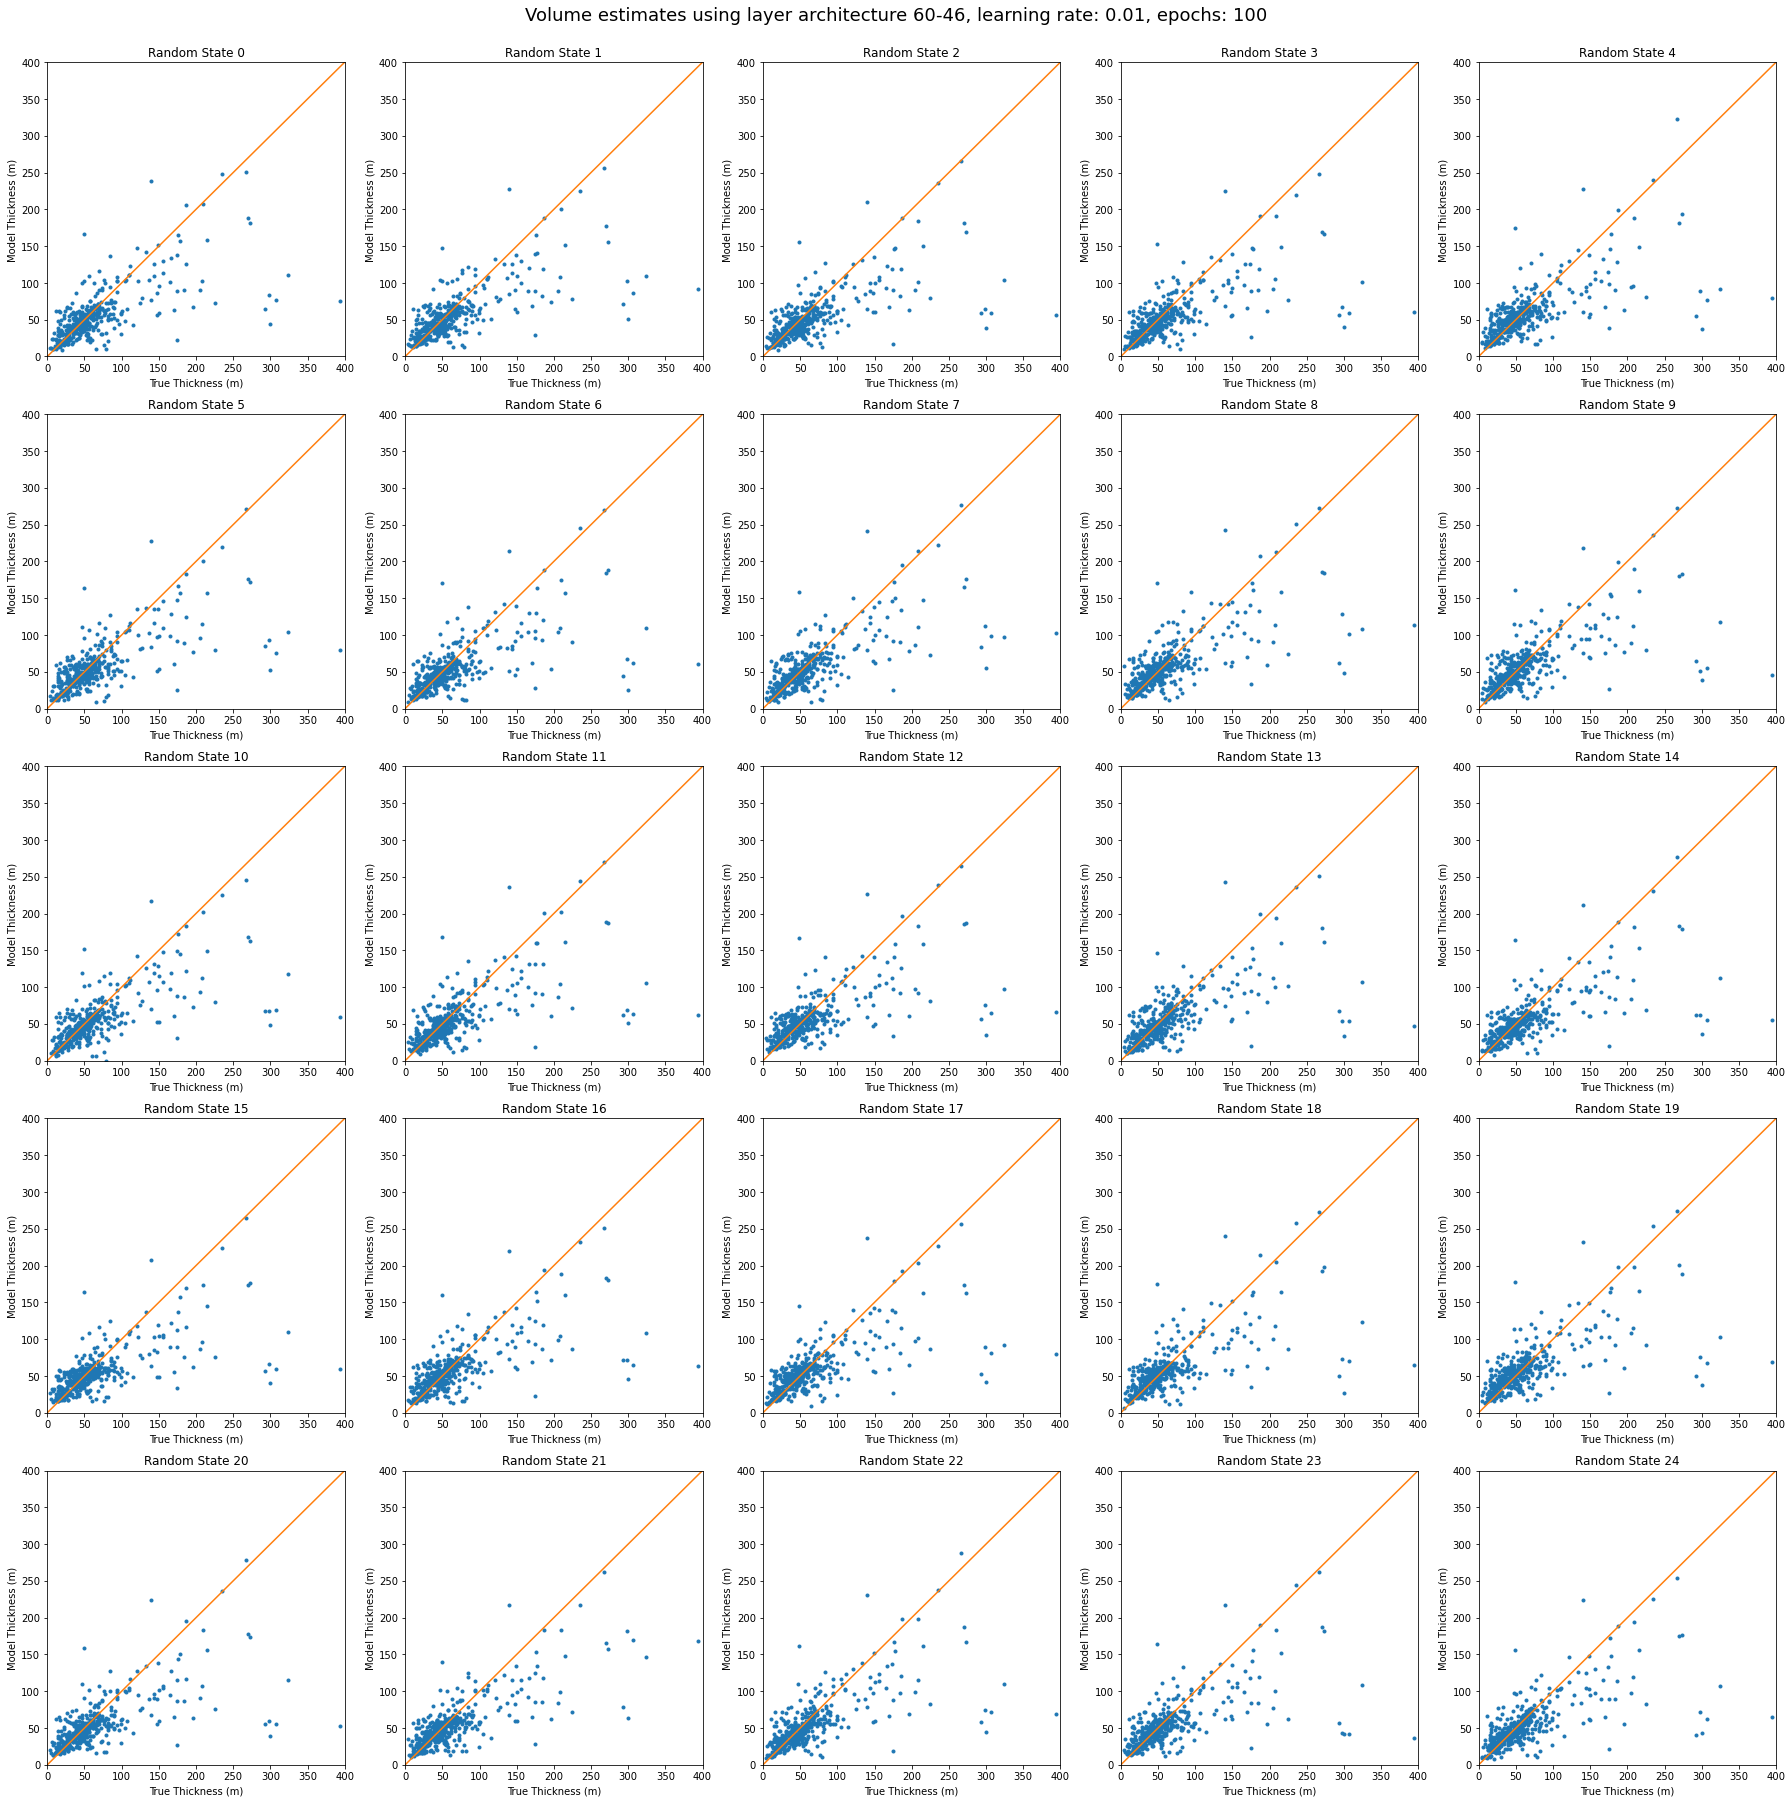

In [48]:
# load selected model and look at predicted accuracies of each random state
print('Please select index from deviations table to inspect further')

selection = int(input())

arch = deviations['layer architecture'].loc[selection]
top_learning_rate = deviations['learning rate'].loc[selection]
epochs = deviations['epochs'].loc[selection]
dropout = deviations['dropout'].loc[selection]
print(arch)
print(top_learning_rate)
print(epochs)
print(dropout)

dnn_model = {}
rootdir = 'saved_models/' + module + '/sm_' + arch + '/'


train_features, test_features, train_labels, test_labels = gl.data_splitter(dataset)
features = pd.concat([train_features, test_features], ignore_index = True)
labels = pd.concat([train_labels, test_labels], ignore_index = True)

fig = plt.figure(figsize=(25, 25))
plt.subplots_adjust(hspace=0.5)
plt.suptitle(
    'Volume estimates using layer architecture ' + arch +
    ', learning rate: ' + str(top_learning_rate) + ', epochs: ' + str(epochs)
             , fontsize=18, y=1
            )
fig.patch.set_facecolor('w')

for n, rs in tqdm(enumerate(RS)):
    ax = plt.subplot(5, 5, n + 1)
    model_name = (
        str(arch) + 
        '_' + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )   
    
    model_path = (
        rootdir + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    dnn_model[model_name] = tf.keras.models.load_model(model_path)
    
    
    y = dnn_model[model_name].predict(features, verbose = 0)
    plt.plot(labels,y,'.')
    plt.plot((0,400),(0,400),'-')
    plt.xlabel('True Thickness (m)')
    plt.ylabel('Model Thickness (m)')
    ax.set_title('Random State ' +str(rs))
    plt.xlim((0,400))
    plt.ylim((0,400))
# plt.tight_layout()

fig_dir = (
    'figs/' + 
    module + 
    '/'   
) 
isdir = os.path.isdir(fig_dir)
if isdir == False:
    os.makedirs(fig_dir)
file_name_1 = (
    fig_dir +
    'predictions_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.eps'
)


file_name_2 = (
    fig_dir +
    'predictions_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.png'
)

plt.tight_layout()
# fig.savefig(file_name_1)
# fig.savefig(file_name_2)

60-46
0.01
100
1
figs/sm8/
saved_results/sr8/sr_60-46/


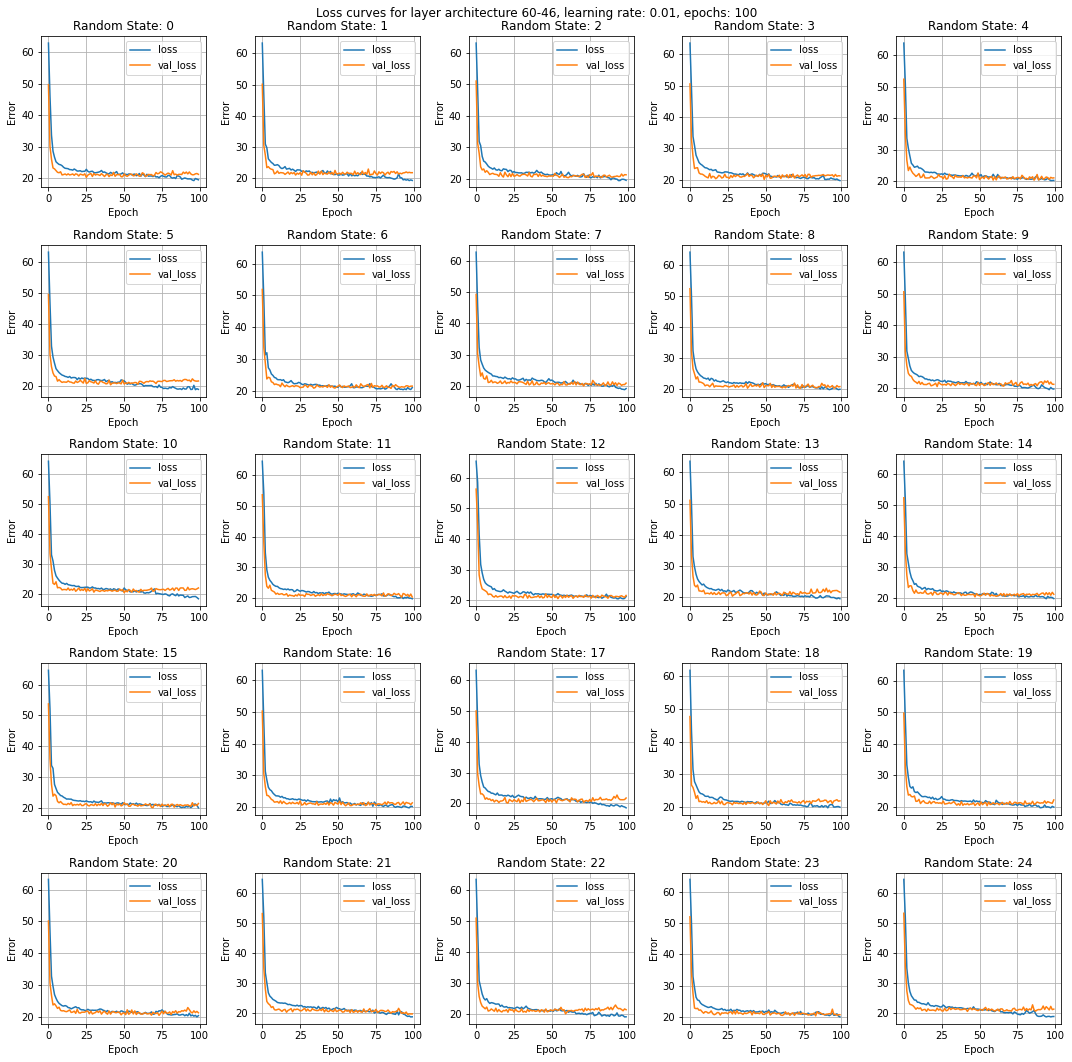

In [49]:
# load selected model loss curves

fig_dir = (
    'figs/' + 
    module + 
    '/'   
) 
isdir = os.path.isdir(fig_dir)
if isdir == False:
    os.makedirs(fig_dir)

print(arch)
print(top_learning_rate)
print(epochs)
print(dropout)

print(fig_dir)
rootdir = 'saved_results/' + res + '/sr_' + arch + '/'
print(rootdir)
dnn_history = {}
fig,ax=plt.subplots(1,1,figsize=(15,15))
fig.patch.set_facecolor('w')
fig.suptitle('Loss curves for layer architecture ' + 
             arch + ', learning rate: ' + str(top_learning_rate) + ', epochs: ' + str(epochs) 
             )
for n, rs in enumerate(RS): 
    ax = plt.subplot(5,5,n+1)
    history_name = (
        arch + 
        '_' +
        dataset.name +
        '_' +
        str(dropout) +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    model_name = (
        dataset.name +
        '_' +
        str(dropout) +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    dnn_history[model_name] = pd.read_csv(rootdir + model_name)


    ax.set_title('Random State: ' + str(rs))
    gl.plot_loss(dnn_history[model_name])
    
file_name_1 = (
    fig_dir +
    'loss_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.eps'
)

file_name_2 = (
    fig_dir +
    'loss_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.png'
)

plt.tight_layout()
# fig.savefig(file_name_1)
# fig.savefig(file_name_2)


# LOAD AND SELECT PRETHICKTIONS

In [51]:
# load prethicktions

root_dir = 'zults/'
RGI_predicted = pd.DataFrame()

# read each prediction file and do stuff to it and append it to a table
for file in tqdm(os.listdir(root_dir)):
    
    if 'RGI_predicted' in file:
        file_reader = pd.read_csv(root_dir + file)
        file_reader['volume'] = (
            file_reader['avg predicted thickness'] / 1e3
        ) * file_reader['Area']
        
        # have to turn something into a series and append it to the df to build it
        sum_volume = sum(file_reader['volume'])
        total_volume = pd.Series(sum_volume, name = 'total volume')
        RGI_predicted = pd.concat([RGI_predicted, total_volume], ignore_index = True)
        
        # stick RGI attribute statistics into df
        if 'df1' not in file:
            att_list = [
                'Area',
                'Aspect',
                'Lmax',
                'Slope',
                'Zmin',
                'Zmax'
            ]
            
            for att in att_list:
                mean = file_reader[att].mean()
                median = file_reader[att].median()
                std = file_reader[att].std()
                q3 = np.quantile(file_reader[att], 0.75)
                q1 = np.quantile(file_reader[att], 0.25)
                iqr = q3 - q1  
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], att + '_RGI_mean'
                ] = mean
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], att + '_RGI_median'
                ] = median
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], att + '_RGI_std'
                ] = std
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], att + '_RGI_iqr'
                ] = iqr
                               
        # variance
        file_reader['variance'] = file_reader['predicted thickness std dev'] **2 
        variance = sum(file_reader['variance'])
        RGI_predicted.loc[
            RGI_predicted.index[-1], 'total variance'
        ] = np.sqrt(variance)/1e3

        # mean thickness
        thickness_mean = file_reader['avg predicted thickness'].mean()
        RGI_predicted.loc[
            RGI_predicted.index[-1], 'mean thickness'
        ] = thickness_mean/1e3
        
#         # max thickness
#         thickness_max = file_reader['avg predicted thickness'].max()
#         RGI_predicted.loc[
#             RGI_predicted.index[-1], 'max model thickness (km)'
#         ] = thickness_max/1e3
        
        # area * mean thickness
        area = sum(file_reader['Area'])
        RGI_predicted.loc[
            RGI_predicted.index[-1], 'vol'
        ] = (area * (thickness_mean/1e3))/1e3
        
        RGI_predicted.loc[
            RGI_predicted.index[-1], 'area'
        ] = area

            
        if 'df1' in file:
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'dataframe'
            ] = 'df1'
            
            RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
            ] = 158.17

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'tolerance'
            ] = 41.0

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'h mean f'
            ] = 224
            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
            if '16-8' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '16-8'
            if '24-12' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '24-12'
        if 'df2' in file:
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'dataframe'
            ] = 'df2'   
            
            RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
            ] = 158.17

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'tolerance'
            ] = 41.0

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'h mean f'
            ] = 224

            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
            if '50-28' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '50-28'
            if '64-48' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '64-48'
        if 'df3' in file:
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'dataframe'
            ] = 'df3'        
             
            
            RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
            ] = 158.17

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'tolerance'
            ] = 41.0

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'h mean f'
            ] = 224
            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
            if '37-20' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '37-20'
            if '59-28' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '59-28'
        if 'df4' in file:
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'dataframe'
            ] = 'df4'    
             
            
            RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
            ] = 158.17

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'tolerance'
            ] = 41.0

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'h mean f'
            ] = 224
            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
                
            if '47-21' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '47-21'
                
            if '64-36' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '64-36'
        if 'df5' in file:
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'dataframe'
            ] = 'df5'    
             
            
            RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
            ] = 158.17

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'tolerance'
            ] = 41.0

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'h mean f'
            ] = 224
            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
                
            if '50-25' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '50-25'
                
            if '64-42' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '64-42'
        if 'df6' in file:
            if 'df6_01' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_01'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 18.98
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 4.92
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 218
                
            if 'df6_02' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_02'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 1.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.27
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 72
                
            if 'df6_03' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_03'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 28.33
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 7.35
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 270
                
            if 'df6_04' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_04'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 8.61
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 2.23
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 210
                
            if 'df6_05' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_05'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 15.69
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 4.07
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 175
                
            if 'df6_06' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_06'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  3.77
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  0.98 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  341 
                
            if 'df6_07' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_07'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  7.47 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  1.94 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  220 
                
            if 'df6_08' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_08'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  0.30 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  0.08 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  101 
                
            if 'df6_09' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_09'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 14.64
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 3.80
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 283
                
            if 'df6_10' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_10'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.14
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.04
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 56
                
            if 'df6_11' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_11'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.13
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.03
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 61
                
            if 'df6_12' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_12'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.02
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 48
                
            if 'df6_13' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_13'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 3.27
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.85
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 66
                
            if 'df6_14' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_14'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 2.87
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.74
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 85
                
            if 'df6_15' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_15'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.88
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.23
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 59
                
            if 'df6_16' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_16'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.10
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.03
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 42
                
            if 'df6_17' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_17'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 5.34
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 1.39
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 181
                
            if 'df6_18' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_18'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.07
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.02
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 63
                
            if 'df6_19' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_19'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 46.47
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 12.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 349
                
                
            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
        if 'df7' in file:
            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
                
            if '50-28' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '50-28'
                
            if '64-48' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '64-48'
                
            if 'df7_01' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_01'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 18.98
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 4.92
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 218
                
            if 'df7_02' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_02'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 1.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.27
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 72
                
            if 'df7_03' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_03'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 28.33
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 7.35
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 270
                
            if 'df7_04' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_04'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 8.61
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 2.23
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 210
                
            if 'df7_05' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_05'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 15.69
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 4.07
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 175
                
            if 'df7_06' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_06'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  3.77
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  0.98 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  341 
                
            if 'df7_07' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_07'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  7.47 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  1.94 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  220 
                
            if 'df7_08' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_08'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  0.30 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  0.08 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  101 
                
            if 'df7_09' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_09'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 14.64
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 3.80
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 283
                
            if 'df7_10' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_10'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.14
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.04
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 56
                
            if 'df7_11' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_11'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.13
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.03
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 61
                
            if 'df7_12' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_12'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.02
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 48
                
            if 'df7_13' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_13'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 3.27
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.85
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 66
                
            if 'df7_14' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_14'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 2.87
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.74
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 85
                
            if 'df7_15' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_15'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.88
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.23
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 59
                
            if 'df7_16' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_16'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.10
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.03
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 42
                
            if 'df7_17' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_17'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 5.34
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 1.39
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 181
                
            if 'df7_18' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_18'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.07
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.02
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 63
                
            if 'df7_19' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_19'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 46.47
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 12.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 349
                
        if 'df8' in file:
            if '60-46' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '60-46'
                
#             if '50-28' in file:
#                 RGI_predicted.loc[
#                     RGI_predicted.index[-1], 'architecture'
#                 ] = '50-28'
                
#             if '64-48' in file:
#                 RGI_predicted.loc[
#                     RGI_predicted.index[-1], 'architecture'
#                 ] = '64-48'
                
            if 'df8_01' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_01'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 18.98
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 4.92
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 218
                
            if 'df8_02' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_02'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 1.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.27
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 72
                
            if 'df8_03' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_03'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 28.33
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 7.35
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 270
                
            if 'df8_04' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_04'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 8.61
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 2.23
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 210
                
            if 'df8_05' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_05'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 15.69
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 4.07
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 175
                
            if 'df8_06' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_06'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  3.77
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  0.98 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  341 
                
            if 'df8_07' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_07'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  7.47 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  1.94 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  220 
                
            if 'df8_08' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_08'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  0.30 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  0.08 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  101 
                
            if 'df8_09' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_09'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 14.64
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 3.80
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 283
                
            if 'df8_10' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_10'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.14
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.04
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 56
                
            if 'df8_11' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_11'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.13
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.03
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 61
                
            if 'df8_12' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_12'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.02
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 48
                
            if 'df8_13' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_13'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 3.27
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.85
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 66
                
            if 'df8_14' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_14'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 2.87
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.74
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 85
                
            if 'df8_15' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_15'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.88
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.23
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 59
                
            if 'df8_16' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_16'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.10
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.03
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 42
                
            if 'df8_17' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_17'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 5.34
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 1.39
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 181
                
            if 'df8_18' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_18'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.07
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.02
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 63
                
            if 'df8_19' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df8_19'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 46.47
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 12.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 349
        if '0.1' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'learning rate']= '0.100'
        if '0.01' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'learning rate']= '0.010'
        if '0.001' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'learning rate']= '0.001'
        if '_20' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '20'
        if '_25' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '25'
        if '_50' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '50'
        if '_60' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '60'
        if '_15' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '15'
        if '_30' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '30'
        if '_40' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '40'
        if '_100' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '100'



# Select prethicktions

# RGI_predicted = RGI_predicted.drop(0, axis=1)
RGI_predicted = RGI_predicted[
    (RGI_predicted['dataframe'].str.contains('df8')) 
#     &
#     (RGI_predicted['architecture'] == '64-48')
#     &
#     (RGI_predicted['learning rate'] == '0.100')
#     &
#     (RGI_predicted['epochs'] == '100')
]

RGI_predicted['mean thickness'] = RGI_predicted['mean thickness'] * 1e3
RGI_predicted['voldiff'] = RGI_predicted['vol'] - RGI_predicted['volf'] 


RGI_predicted = RGI_predicted.sort_values([
#     'mean thickness (km)',
#     'architecture',
#     'learning rate',
    'dataframe'
], ascending = True)

RGI_predicted = RGI_predicted.reset_index()

RGI_predicted = RGI_predicted.drop('index', axis = 1)
# RGI_predicted = RGI_predicted[
#     RGI_predicted['vol'] < 300
# ]
RGI = RGI_predicted.copy()
df = RGI.copy()

100%|██████████| 298/298 [00:09<00:00, 29.89it/s]


In [52]:
# finish building df

dfa = pd.DataFrame()
pth_3 = '/data/fast1/glacierml/data/regional_data/raw/'
for file in tqdm(os.listdir(pth_3)):
    dfb = pd.read_csv(pth_3 + file, encoding_errors = 'replace', on_bad_lines = 'skip')
    region_and_number = file[:-4]
    region_number = region_and_number[:2]
    region = region_and_number[3:]

    dfb['geographic region'] = region
    dfb['region'] = region_number
    dfa = dfa.append(dfb, ignore_index=True)

dfa = dfa.reset_index()

dfa = dfa[[
    'GlaThiDa_index',
    'RGI_index',
    'RGIId',
    'region',
    'geographic region'
]]

pth = '/data/fast1/glacierml/data/RGI/rgi60-attribs/'
pth_2 = '/data/fast1/glacierml/data/regional_data/training_data/'
RGI_extra = pd.DataFrame()
for file in os.listdir(pth):
    f = pd.read_csv(pth + file, encoding_errors = 'replace', on_bad_lines = 'skip')
    RGI_extra = pd.concat([RGI_extra, f], ignore_index = True)

    region_and_number = file[:-4]
    region_number = region_and_number[:2]
    region = region_and_number[9:]
    dfc = dfa[dfa['region'] == region_number]
    
    for file in os.listdir(pth_2):
        if file[:2] == region_number:
            glathida_regional = pd.read_csv(pth_2 + file)

    GlaThiDa_mean_area = glathida_regional['Area'].mean()
    GlaThiDa_mean_aspect = glathida_regional['Aspect'].mean()
    GlaThiDa_mean_lmax = glathida_regional['Lmax'].mean()
    GlaThiDa_mean_slope = glathida_regional['Slope'].mean()
    GlaThiDa_mean_zmin = glathida_regional['Zmin'].mean()
    GlaThiDa_mean_zmax = glathida_regional['Zmax'].mean()
    
    GlaThiDa_median_area = glathida_regional['Area'].median()
    GlaThiDa_median_aspect = glathida_regional['Aspect'].median()
    GlaThiDa_median_lmax = glathida_regional['Lmax'].median()
    GlaThiDa_median_slope = glathida_regional['Slope'].median()
    GlaThiDa_median_zmin = glathida_regional['Zmin'].median()
    GlaThiDa_median_zmax = glathida_regional['Zmax'].median()
    
    GlaThiDa_std_area = glathida_regional['Area'].std(ddof=0)
    GlaThiDa_std_aspect = glathida_regional['Aspect'].std(ddof=0)
    GlaThiDa_std_lmax = glathida_regional['Lmax'].std(ddof=0)
    GlaThiDa_std_slope = glathida_regional['Slope'].std(ddof=0)
    GlaThiDa_std_zmin = glathida_regional['Zmin'].std(ddof=0)
    GlaThiDa_std_zmax = glathida_regional['Zmax'].std(ddof=0)
    
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Area_GlaThiDa_mean'
    ] = GlaThiDa_mean_area
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Aspect_GlaThiDa_mean'
    ] = GlaThiDa_mean_aspect
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Lmax_GlaThiDa_mean'
    ] = GlaThiDa_mean_lmax
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Slope_GlaThiDa_mean'
    ] = GlaThiDa_mean_slope
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Zmin_GlaThiDa_mean'
    ] = GlaThiDa_mean_zmin
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Zmax_GlaThiDa_mean'
    ] = GlaThiDa_mean_zmax
    
    
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Area_GlaThiDa_median'
    ] = GlaThiDa_median_area
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Aspect_GlaThiDa_median'
    ] = GlaThiDa_median_aspect
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Lmax_GlaThiDa_median'
    ] = GlaThiDa_median_lmax
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Slope_GlaThiDa_median'
    ] = GlaThiDa_median_slope
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Zmin_GlaThiDa_median'
    ] = GlaThiDa_median_zmin
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Zmax_GlaThiDa_median'
    ] = GlaThiDa_median_zmax
    
    
    
    
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Area_GlaThiDa_std'
    ] = GlaThiDa_std_area
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Aspect_GlaThiDa_std'
    ] = GlaThiDa_std_aspect
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Lmax_GlaThiDa_std'
    ] = GlaThiDa_std_lmax
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Slope_GlaThiDa_std'
    ] = GlaThiDa_std_slope
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Zmin_GlaThiDa_std'
    ] = GlaThiDa_std_zmin
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Zmax_GlaThiDa_std'
    ] = GlaThiDa_std_zmax
    
    
    
    
    
    
    trainable_ratio = (len(dfc) / len(f))
    percent_trainable = trainable_ratio * 100
    
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'ratio trainable'
    ] = trainable_ratio

#     print(df['dataframe'].str[4:][df['dataframe'].str[4:] == region_number])   
    
#     if reg == region_number:
        
#         print(df['dataframe'])
#     index = df[df['dataframe'][3:] == region_number].index
#     df['dataframe'].loc[index]
#     print(df['dataframe'].loc[index])
    
#     print(
#         'region ' + str(region_number) + ' has ' + str(len(f)) + ' lines of data, ' +
#         str(len(dfc)) + ' or ' + str(percent_trainable) +
#         '% of which are trainable with GlaThiDa thicknesses'    
#     )
df['vol_ratio'] = df['vol'] / df['volf']
df['vol_from_zero'] = abs(1 - df['vol_ratio'])


100%|██████████| 15/15 [00:00<00:00, 360.70it/s]


In [53]:
# compute residuals
residuals = df[[
    'dataframe',
    'vol_ratio',
    'vol_from_zero',
    'voldiff',
]]

residuals['percent error'] = abs(
   ( 1 - residuals['vol_ratio']) * 100
)
residuals['region'] = residuals['dataframe'].str[4:]
residuals = residuals.drop('dataframe', axis = 1)

In [54]:
df

,0,Area_RGI_iqr,Area_RGI_mean,Area_RGI_median,Area_RGI_std,Aspect_RGI_iqr,Aspect_RGI_mean,Aspect_RGI_median,Aspect_RGI_std,Lmax_RGI_iqr,Lmax_RGI_mean,Lmax_RGI_median,Lmax_RGI_std,Slope_RGI_iqr,Slope_RGI_mean,Slope_RGI_median,Slope_RGI_std,Zmax_RGI_iqr,Zmax_RGI_mean,Zmax_RGI_median,Zmax_RGI_std,Zmin_RGI_iqr,Zmin_RGI_mean,Zmin_RGI_median,Zmin_RGI_std,architecture,area,dataframe,epochs,h mean f,learning rate,mean thickness,tolerance,total variance,vol,volf,voldiff,Area_GlaThiDa_mean,Aspect_GlaThiDa_mean,Lmax_GlaThiDa_mean,Slope_GlaThiDa_mean,Zmin_GlaThiDa_mean,Zmax_GlaThiDa_mean,Area_GlaThiDa_median,Aspect_GlaThiDa_median,Lmax_GlaThiDa_median,Slope_GlaThiDa_median,Zmin_GlaThiDa_median,Zmax_GlaThiDa_median,Area_GlaThiDa_std,Aspect_GlaThiDa_std,Lmax_GlaThiDa_std,Slope_GlaThiDa_std,Zmin_GlaThiDa_std,Zmax_GlaThiDa_std,ratio trainable,vol_ratio,vol_from_zero
0,36280.215895,0.68100,3.199242,0.3130,41.810153,234.00,192.250848,215.0,119.556115,1079.00,1532.236388,744.0,4166.345049,9.000,24.023993,23.0,7.280360,609.00,1816.157186,1797.0,554.464460,626.00,1337.327542,1334.0,500.317301,60-46,86725.053,df8_01,100,218.0,0.010,113.972401,4.92,4.132285,9.884262,18.98,-9.095738,31.746125,178.125000,7208.750000,18.625000,1505.125000,2278.000000,1.8260,206.0,2351.0,21.00,1579.5,2554.0,76.730266,116.309326,13254.758068,5.452924,735.136116,800.062341,0.000295,0.520773,0.479227
1,1608.916746,0.47200,0.770312,0.1820,4.561523,260.00,153.637072,103.0,127.722660,699.00,907.091806,567.0,1219.842485,9.500,24.509075,24.2,7.448535,678.00,2418.342668,2348.0,575.395510,651.00,2075.797666,1974.0,620.405019,60-46,14524.224,df8_02,100,72.0,0.010,120.942377,0.27,1.801726,1.756594,1.06,0.696594,2.062406,168.531250,2526.000000,21.178125,2241.687500,3116.937500,1.1850,162.5,2138.0,20.80,2007.5,3011.0,3.074268,120.333387,2238.034517,5.621317,601.644384,608.579182,0.001697,1.657164,0.657164
2,51297.407074,6.79250,23.070817,1.7600,124.383384,240.00,181.400351,182.5,120.892604,3482.25,4463.788850,1884.5,7963.540144,7.700,15.425593,14.3,6.122999,487.00,1052.250658,1059.0,370.618137,418.00,509.114355,524.0,294.020249,60-46,105110.642,df8_03,100,270.0,0.010,93.128857,7.35,4.468865,9.788834,28.33,-18.541166,1238.533333,259.000000,54630.333333,6.100000,16.000000,1419.666667,999.8610,323.0,71606.0,6.30,0.0,1921.0,1046.519763,92.639085,32082.883332,0.509902,22.627417,819.563434,0.000658,0.345529,0.654471
3,11177.885557,2.14750,5.514259,0.6570,43.879279,236.00,172.181254,163.0,120.474964,1924.50,2331.581389,1191.0,3683.474811,7.100,17.700000,16.9,5.800160,447.50,1119.713554,1120.0,315.732986,389.00,700.133378,695.0,303.851676,60-46,40888.228,df8_04,100,210.0,0.010,89.411908,2.23,2.172808,3.655894,8.61,-4.954106,1479.180000,30.500000,31318.000000,7.300000,420.500000,1452.000000,1479.1800,30.5,31318.0,7.30,420.5,1452.0,1292.232000,20.500000,1445.000000,3.700000,17.500000,335.000000,0.000270,0.424610,0.575390
4,88941.292983,1.70700,6.419780,0.3930,79.435060,216.00,179.712847,177.0,114.509047,1606.00,2042.080944,838.0,3956.243506,12.900,20.428543,19.6,9.222722,668.00,1253.531859,1221.0,488.893555,610.00,781.344948,761.0,436.516045,60-46,130071.155,df8_05,100,175.0,0.010,91.139490,4.07,6.070790,11.854619,15.69,-3.835381,20.154000,261.000000,8083.000000,11.300000,159.000000,983.000000,20.1540,261.0,8083.0,11.30,159.0,983.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000049,0.755553,0.244447
5,5553.423431,2.58150,19.471303,0.5635,117.008230,229.00,170.183099,152.0,117.829151,2093.25,3142.669014,983.0,6821.225502,8.625,17.573592,16.7,6.660431,244.25,1291.170775,1267.0,265.430755,267.75,889.221831,935.5,264.211462,60-46,11059.700,df8_06,100,341.0,0.010,96.198378,0.98,1.479420,1.063925,3.77,-2.706075,608.658000,142.000000,28302.666667,11.366667,477.666667,1511.000000,264.5360,117.0,22676.0,7.30,607.0,1762.0,682.150351,41.880783,25153.662349,7.512360,262.994719,499.241425,0.005282,0.282208,0.717792
6,8707.631954,7.09350,21.027204,1.8740,78.127422,234.00,174.302167,164.0,120.216

In [55]:
residuals.sort_values('percent error')

,vol_ratio,vol_from_zero,voldiff,percent error,region
7,0.981934,0.018066,-0.005420,1.806609,08
16,0.822092,0.177908,-0.950030,17.790833,17
4,0.755553,0.244447,-3.835381,24.444750,05
13,1.254478,0.254478,0.730352,25.447807,14
18,0.536643,0.463357,-21.532200,46.335699,19
0,0.520773,0.479227,-9.095738,47.922748,01
6,0.459496,0.540504,-4.037563,54.050378,07
8,0.439594,0.560406,-8.204339,56.040565,09
3,0.424610,0.575390,-4.954106,57.538972,04
10,1.597004,0.597004,0.077611,59.700386,11


# VOLUME ESTIMATE SCATTER PLOTS

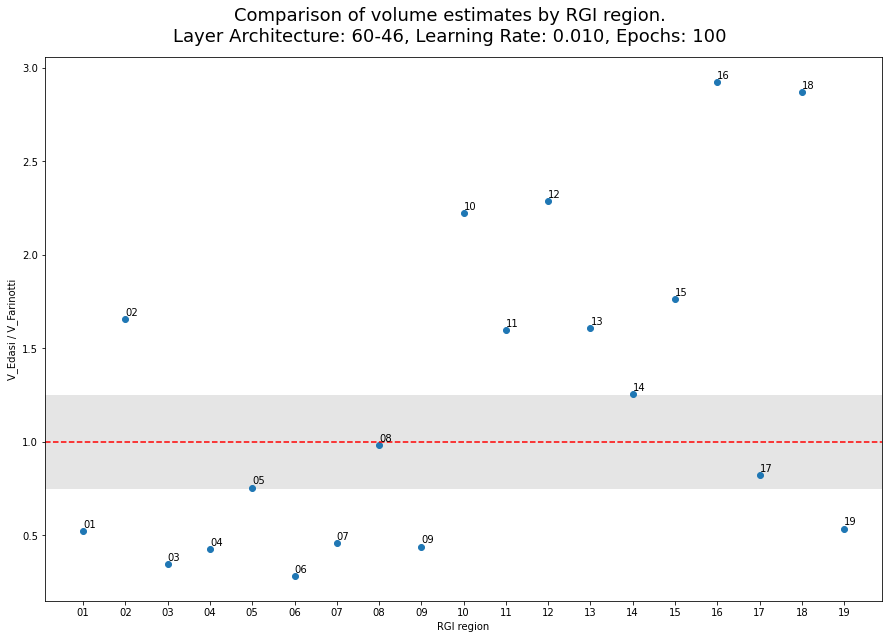

In [57]:
# volume comparisons by RGI region
dfq = df[[
    'dataframe',
    'vol',
    'volf',
    'ratio trainable'
]]
ratio = dfq.vol / dfq.volf

fig, ax = plt.subplots(1,1,figsize = (15,10))
fig.patch.set_facecolor('w')
plt.axhline(y = 1.00, color = 'red', linestyle = '--')

ax.fill_between(
    x = (-10,30),
    y1 = 1.25,
    y2 = 0.75,
    facecolor = 'gray',
    alpha = 0.2
)


arch = df['architecture'].iloc[-1]
learningrate = df['learning rate'].iloc[-1]
epochs = df['epochs'].iloc[-1]
plt.suptitle(
    'Comparison of volume estimates by RGI region.' + 
    '\nLayer Architecture: ' + df['architecture'].iloc[-1] +
    ', Learning Rate: ' + df['learning rate'].iloc[-1] +
    ', Epochs: ' + df['epochs'].iloc[-1],
    fontsize=18, y=0.95
)
ax.set(ylabel = 'V_Edasi / V_Farinotti', xlabel = 'RGI region')
plt.scatter(x = dfq['dataframe'].str[4:], y = ratio)
for i in dfq['dataframe'].index:
    plt.text(
        x = int(df['dataframe'].str[4:].loc[i]) - 1,
        y = (
            ratio.loc[i]
        ) + 0.02,
        s = df['dataframe'].str[4:].loc[i]
    )

# fig.savefig('figs/Vcomparison_region_' + arch + '_' + learningrate + '_' + epochs + '.png')
# fig.savefig('figs/Vcomparison_region_' + arch + '_' + learningrate + '_' + epochs + '.eps')

In [ ]:
# volume estimates by region and trainable inputs

dfq = df[[
    'dataframe',
    'vol',
    'volf',
    'ratio trainable'
]]
ratio = dfq.vol / dfq.volf

fig, ax = plt.subplots(1,1,figsize = (15,10))
fig.patch.set_facecolor('w')
plt.axhline(y = 1.00, color = 'red', linestyle = '--')
plt.suptitle('Comparison of volume estimates by trainable inputs using layer architecture ' + 
    df['architecture'].iloc[-1], fontsize=18, y=0.95)
ax.set(ylabel = 'V_Edasi / V_Farinotti', xlabel = 'Ratio of GlaThiDa glaciers in RGI')
plt.scatter(x = dfq['ratio trainable'], y = ratio)

ax.fill_between(
    x = (
        dfq['ratio trainable'].min(), dfq['ratio trainable'].max()
    ),
    y1 = 1.25,
    y2 = 0.75,
    facecolor = 'gray',
    alpha = 0.2
)
# ax.set_xscale('log')




# for i in dfq['dataframe'].index:
#     plt.text(
#         x = dfq['ratio trainable'].loc[i],
#         y = (
#             dfq['vol'] / dfq['volf'].loc[i]
#         ) + 0.02,
#         s = df['dataframe'].str[4:].loc[i]
#     )
# plt.semilogx()

# fig.savefig('figs/Vcomparison_trainable.png')
# fig.savefig('figs/Vcomparison_trainable.eps')

In [ ]:
# volume estimates of RGI regions by RGI attribute mean value 
dfr = df[[
    'Area_RGI_mean',
    'Aspect_RGI_mean',
    'Lmax_RGI_mean',
    'Slope_RGI_mean',
    'Zmax_RGI_mean',
    'Zmin_RGI_mean'
]]

ratio = df.vol / df.volf

fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Volume estimates by RGI attribute mean value.' + 
    '\nLayer Architecture: ' + df['architecture'].iloc[-1] +
    ', Learning Rate: ' + df['learning rate'].iloc[-1] + 
    ', Epochs: ' + df['epochs'].iloc[-1], fontsize=18, y=0.95)
fig.patch.set_facecolor('w')
for n, col in enumerate(dfr.columns):
    ax = plt.subplot(3, 2, n + 1)
    dfr[dfr[col] == col].plot(ax=ax)
    
    plt.scatter(x = dfr[col], y = ratio)
    
    ax.fill_between(
        x = (
            dfr[col].min(), dfr[col].max()
        ),
        y1 = 1.25,
        y2 = 0.75,
        facecolor = 'gray',
        alpha = 0.2
    )
    
    plt.axhline(y = 1.00, color = 'red', linestyle = '--')
    
    ax.set_title(col[:-9].upper())
    ax.get_legend().remove()
    ax.set_xlabel('RGI Mean ' + col[:-9])
    ax.set_ylabel('V_Edasi / V_Farinotti')
    
    
#     for i in dfr[col].index:
#         plt.text(
#             x = dfr[col].loc[i],
#             y = (
#                 df['vol'].loc[i] / df['volf'].loc[i]
#             ) + 0.02,
#             s = df['dataframe'].str[4:].loc[i]
#         )
# fig.savefig(
#     'figs/Vcomparison_RGI_attribute_mean_' + 
#     arch + '_' + learningrate + '_' + epochs + '.png'
# )
# fig.savefig(
#     'figs/Vcomparison_RGI_attribute_mean_' + 
#     arch + '_' + learningrate + '_' + epochs + '.eps'
# )

In [ ]:
# volume estimates of RGI regions by RGI median attribute value 

dfs = df[[
    'vol',
    'volf'
]]
dfr = df[[
    'Area_RGI_median',
    'Aspect_RGI_median',
    'Lmax_RGI_median',
    'Slope_RGI_median',
    'Zmax_RGI_median',
    'Zmin_RGI_median'
]]
ratio = dfs.vol / dfs.volf

fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Volume estimates by RGI attribute median value.' + 
    '\nLayer Architecture: ' + df['architecture'].iloc[-1] +
    ', Learning Rate: ' + df['learning rate'].iloc[-1] +
    ', Epochs: ' + df['epochs'].iloc[-1], fontsize=18, y=0.95)
fig.patch.set_facecolor('w')
# fig.patch.set_facecolor('w')
# loop through the length of tickers and keep track of index
for n, col in enumerate(dfr.columns):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)
#     fig = plt.figure()
    # filter df and plot ticker on the new subplot axis
    dfr[dfr[col] == col].plot(ax=ax)
    plt.scatter(x = dfr[col], y = ratio)
    
    ax.fill_between(
        x = (
            dfr[col].min(), dfr[col].max()
        ),
        y1 = 1.25,
        y2 = 0.75,
        facecolor = 'gray',
        alpha = 0.2
    )
    
    plt.axhline(y = 1.00, color = 'red', linestyle = '--')
    
    # chart formatting
    ax.set_title(col[:-11].upper())
    ax.get_legend().remove()
    ax.set_xlabel('RGI median ' + col[:-11])
    ax.set_ylabel('V_Edasi / V_Farinotti')
#     plt.xscale('log')

# fig.savefig('figs/Vcomparison_RGI_attribute_median_' + 
#             arch + '_' + learningrate + '_' + epochs + '.png'
#            )
# fig.savefig('figs/Vcomparison_RGI_attribute_median_' + 
#             arch + '_' + learningrate + '_' + epochs + '.eps'
#            )

In [ ]:
# volume estimates by GlaThiDa mean value for each attribute   

dfs = df[[
    'vol',
    'volf'
]]
dfr = df[[
    'Area_GlaThiDa_mean',
    'Aspect_GlaThiDa_mean',
    'Lmax_GlaThiDa_mean',
    'Slope_GlaThiDa_mean',
    'Zmax_GlaThiDa_mean',
    'Zmin_GlaThiDa_mean'
]]
ratio = dfs.vol / dfs.volf

fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Volume estimates by GlaThiDa attribute mean value.' + 
    '\nLayer Architecture: ' + df['architecture'].iloc[-1] +
    ', Learning Rate: ' + df['learning rate'].iloc[-1] + 
    ', Epochs: ' + df['epochs'].iloc[-1], fontsize=18, y=0.95)
fig.patch.set_facecolor('w')
# fig.patch.set_facecolor('w')
# loop through the length of tickers and keep track of index
for n, col in enumerate(dfr.columns):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)
#     fig = plt.figure()
    # filter df and plot ticker on the new subplot axis
    dfr[dfr[col] == col].plot(ax=ax)
    plt.scatter(x = dfr[col], y = ratio)
    
    ax.fill_between(
        x = (
            dfr[col].min(), dfr[col].max()
        ),
        y1 = 1.25,
        y2 = 0.75,
        facecolor = 'gray',
        alpha = 0.2
    )
    
    plt.axhline(y = 1.00, color = 'red', linestyle = '--')
    
    # chart formatting
    ax.set_title(col[:-14].upper())
    ax.get_legend().remove()
    ax.set_xlabel('GlaThiDa Mean ' + col[:-14])
    ax.set_ylabel('V_Edasi / V_Farinotti')
    if col == 'Area_GlaThiDa_mean':
        plt.xscale('log')
        

# fig.savefig('figs/Vcomparison_GlaThiDa_attribute_' + 
#             arch + '_' + learningrate + '_' + epochs + '.png'
#            )
# fig.savefig('figs/Vcomparison_GlaThiDa_attribute_' + 
#             arch + '_' + learningrate + '_' + epochs + '.eps'
#            )

In [ ]:
# volume estimates by GlaThiDa median value for each attribute

dfs = df[[
    'vol',
    'volf'
]]
dfr = df[[
    'Area_GlaThiDa_median',
    'Aspect_GlaThiDa_median',
    'Lmax_GlaThiDa_median',
    'Slope_GlaThiDa_median',
    'Zmax_GlaThiDa_median',
    'Zmin_GlaThiDa_median'
]]
ratio = dfs.vol / dfs.volf

fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Volume estimates by GlaThiDa attribute median value.' + 
    '\nLayer Architecture: ' + df['architecture'].iloc[-1] +
    ', Learning Rate: ' + df['learning rate'].iloc[-1] +
    ', Epochs: ' + df['epochs'].iloc[-1], fontsize=18, y=0.95)
fig.patch.set_facecolor('w')
# fig.patch.set_facecolor('w')
# loop through the length of tickers and keep track of index
for n, col in enumerate(dfr.columns):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)
#     fig = plt.figure()
    # filter df and plot ticker on the new subplot axis
    dfr[dfr[col] == col].plot(ax=ax)
    plt.scatter(x = dfr[col], y = ratio)
    
    ax.fill_between(
        x = (
            dfr[col].min(), dfr[col].max()
        ),
        y1 = 1.25,
        y2 = 0.75,
        facecolor = 'gray',
        alpha = 0.2
    )
    
    plt.axhline(y = 1.00, color = 'red', linestyle = '--')
    
    # chart formatting
    ax.set_title(col[:-16].upper())
    ax.get_legend().remove()
    ax.set_xlabel('GlaThiDa median ' + col[:-16])
    ax.set_ylabel('V_Edasi / V_Farinotti')
    if col[:-16] == 'Area':
        
        plt.xscale('log')

# fig.savefig('figs/Vcomparison_GlaThiDa_median_' + 
#             arch + '_' + learningrate + '_' + epochs + '.png'
#            )
# fig.savefig('figs/Vcomparison_GlaThida_median_' + 
#             arch + '_' + learningrate + '_' + epochs + '.eps'
#            )

# DATASET COMPARISON SCATTER PLOTS

In [ ]:
# volume estimates against ratio of trainable glaciers in each region 

dfs = df[[
    'vol',
    'volf'
]]
dfr = df[[
    'Area_RGI_mean',
    'Aspect_RGI_mean',
    'Lmax_RGI_mean',
    'Slope_RGI_mean',
    'Zmax_RGI_mean',
    'Zmin_RGI_mean'
]]
dfr = dfr.rename(columns = {
    'Area_RGI_mean':'Area',
    'Aspect_RGI_mean':'Aspect',
    'Lmax_RGI_mean':'Lmax',
    'Slope_RGI_mean':'Slope',
    'Zmax_RGI_mean':'Zmax',
    'Zmin_RGI_mean':'Zmin'
})

dfg = df[[
    'Area_GlaThiDa_mean',
    'Aspect_GlaThiDa_mean',
    'Lmax_GlaThiDa_mean',
    'Slope_GlaThiDa_mean',
    'Zmax_GlaThiDa_mean',
    'Zmin_GlaThiDa_mean'
]]
dfg = dfg.rename(columns = {
    'Area_GlaThiDa_mean':'Area',
    'Aspect_GlaThiDa_mean':'Aspect',
    'Lmax_GlaThiDa_mean':'Lmax',
    'Slope_GlaThiDa_mean':'Slope',
    'Zmax_GlaThiDa_mean':'Zmax',
    'Zmin_GlaThiDa_mean':'Zmin'
})
ratio = dfs.vol / dfs.volf



fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Attribute comparison between GlaThiDa and RGI.' + 
    '\nLayer Architecture: ' + df['architecture'].iloc[-1] +
    ', Learning Rate: ' + df['learning rate'].iloc[-1] +
    ', Epochs: ' + df['epochs'].iloc[-1], fontsize=18, y=0.95)
fig.patch.set_facecolor('w')
# fig.patch.set_facecolor('w')
# loop through the length of tickers and keep track of index
for n, col in enumerate(dfr.columns):
#     print(list(dfg.columns.str[:-14]))
    if col in list(dfg.columns):
        
        
    # add a new subplot iteratively
        ax = plt.subplot(3, 2, n + 1)
        dfr[dfr[col] == col].plot(ax=ax)
        plt.scatter(x = dfg[col] / dfr[col], y = ratio)
        
        ax.fill_between(
            x = (
                (dfg[col] / dfr[col]).min(), (dfg[col] / dfr[col]).max()
            ),
            y1 = 1.25,
            y2 = 0.75,
            facecolor = 'gray',
            alpha = 0.2
        )

        plt.axhline(y = 1.00, color = 'red', linestyle = '--')

        # chart formatting
        ax.set_title(col.upper())
        ax.get_legend().remove()
        ax.set_xlabel('GlaThiDa mean / RGI mean ')
        ax.set_ylabel('V_Edasi / V_Farinotti')
        if col == 'Area':
            plt.xscale('log')

#         plt.semilogx()
# fig.savefig('figs/Vcomparison_GandR_attribute_mean_' + 
#             arch + '_' + learningrate + '_' + epochs + '.png'
#            )
# fig.savefig('figs/Vcomparison_GandR_attribute_mean_' + 
#             arch + '_' + learningrate + '_' + epochs + '.eps'
#            )

In [ ]:
# volume estimates against median ratio of trainable glaciers by region 

dfs = df[[
    'vol',
    'volf'
]]
dfr = df[[
    'Area_RGI_median',
    'Aspect_RGI_median',
    'Lmax_RGI_median',
    'Slope_RGI_median',
    'Zmax_RGI_median',
    'Zmin_RGI_median'
]]
dfr = dfr.rename(columns = {
    'Area_RGI_median':'Area',
    'Aspect_RGI_median':'Aspect',
    'Lmax_RGI_median':'Lmax',
    'Slope_RGI_median':'Slope',
    'Zmax_RGI_median':'Zmax',
    'Zmin_RGI_median':'Zmin'
})

dfg = df[[
    'Area_GlaThiDa_median',
    'Aspect_GlaThiDa_median',
    'Lmax_GlaThiDa_median',
    'Slope_GlaThiDa_median',
    'Zmax_GlaThiDa_median',
    'Zmin_GlaThiDa_median'
]]
dfg = dfg.rename(columns = {
    'Area_GlaThiDa_median':'Area',
    'Aspect_GlaThiDa_median':'Aspect',
    'Lmax_GlaThiDa_median':'Lmax',
    'Slope_GlaThiDa_median':'Slope',
    'Zmax_GlaThiDa_median':'Zmax',
    'Zmin_GlaThiDa_median':'Zmin'
})
ratio = dfs.vol / dfs.volf



fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Attribute comparison between GlaThiDa and RGI.' + 
    '\nLayer Architecture: ' + df['architecture'].iloc[-1] +
    ', Learning Rate: ' + df['learning rate'].iloc[-1] +
    ', Epochs: ' + df['epochs'].iloc[-1], fontsize=18, y=0.95)
fig.patch.set_facecolor('w')
# fig.patch.set_facecolor('w')
# loop through the length of tickers and keep track of index
for n, col in enumerate(dfr.columns):
#     print(list(dfg.columns.str[:-14]))
    if col in list(dfg.columns):
        
        
    # add a new subplot iteratively
        ax = plt.subplot(3, 2, n + 1)
        dfr[dfr[col] == col].plot(ax=ax)
        plt.scatter(x = dfg[col] / dfr[col], y = ratio)
        
        ax.fill_between(
            x = (
                (dfg[col] / dfr[col]).min(), (dfg[col] / dfr[col]).max()
            ),
            y1 = 1.25,
            y2 = 0.75,
            facecolor = 'gray',
            alpha = 0.2
        )

        plt.axhline(y = 1.00, color = 'red', linestyle = '--')

        # chart formatting
        ax.set_title(col.upper())
        ax.get_legend().remove()
        ax.set_xlabel('GlaThiDa median / RGI median ')
        ax.set_ylabel('V_Edasi / V_Farinotti')
        if col == 'Area':
            plt.xscale('log')

#         plt.semilogx()
# fig.savefig('figs/Vcomparison_GandR_attribute_median' + 
#             arch + '_' + learningrate + '_' + epochs + '.png')
# fig.savefig('figs/Vcomparison_GandR_attribute_median' + 
#             arch + '_' + learningrate + '_' + epochs + '.eps')

In [ ]:
# GlaThiDa mean value against RGI mean value by attribute 

dfs = df[[
    'vol',
    'volf'
]]
dfr = df[[
    'Area_RGI_mean',
    'Aspect_RGI_mean',
    'Lmax_RGI_mean',
    'Slope_RGI_mean',
    'Zmax_RGI_mean',
    'Zmin_RGI_mean'
]]
dfr = dfr.rename(columns = {
    'Area_RGI_mean':'Area',
    'Aspect_RGI_mean':'Aspect',
    'Lmax_RGI_mean':'Lmax',
    'Slope_RGI_mean':'Slope',
    'Zmax_RGI_mean':'Zmax',
    'Zmin_RGI_mean':'Zmin'
})

dfg = df[[
    'Area_GlaThiDa_mean',
    'Aspect_GlaThiDa_mean',
    'Lmax_GlaThiDa_mean',
    'Slope_GlaThiDa_mean',
    'Zmax_GlaThiDa_mean',
    'Zmin_GlaThiDa_mean'
]]
dfg = dfg.rename(columns = {
    'Area_GlaThiDa_mean':'Area',
    'Aspect_GlaThiDa_mean':'Aspect',
    'Lmax_GlaThiDa_mean':'Lmax',
    'Slope_GlaThiDa_mean':'Slope',
    'Zmax_GlaThiDa_mean':'Zmax',
    'Zmin_GlaThiDa_mean':'Zmin'
})
ratio = dfs.vol / dfs.volf

# Area = dfr['Area_GlaThiDa_mean'] / dfr['Area_RGI_mean']
# Aspect = dfr['Aspect_GlaThiDa_mean'] / dfr['Aspect_RGI_mean']
# Lmax = dfr['Lmax_GlaThiDa_mean'] / dfr['Lmax_RGI_mean']
# Slope = dfr['Slope_GlaThiDa_mean'] / dfr['Slope_RGI_mean']
# Zmax = dfr['Zmax_GlaThiDa_mean'] / dfr['Zmax_RGI_mean']
# Zmin = dfr['Zmin_GlaThiDa_mean'] / dfr['Zmin_RGI_mean']


fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Attribute comparison between GlaThiDa and RGI mean', fontsize=18, y=0.95)
fig.patch.set_facecolor('w')
# fig.patch.set_facecolor('w')
# loop through the length of tickers and keep track of index
for n, col in enumerate(dfr.columns):
#     print(list(dfg.columns.str[:-14]))
    if col in list(dfg.columns):
        
        
    # add a new subplot iteratively
        ax = plt.subplot(3, 2, n + 1)
        dfr[dfr[col] == col].plot(ax=ax)
        plt.scatter(x = dfr[col], y = dfg[col])

#         plt.axhline(y = 1.00, color = 'red', linestyle = '--')
        plt.plot(
            (dfr[col].min(), dfr[col].max()),
            (dfr[col].min(), dfr[col].max()),
            '-'
        )
        # chart formatting
        ax.set_title(col.upper())
        ax.get_legend().remove()
        ax.set_xlabel('RGI mean ' + col)
        ax.set_ylabel('GlaThiDa mean ' + col)
        if col == 'Area' or col == 'Lmax':
#             plt.xscale('log')
            plt.yscale('log')
# fig.savefig('figs/GlaThiDa_RGI_attribute_mean.png')
# fig.savefig('figs/GlaThiDa_RGI_attribute_mean.eps')

In [ ]:
# GlaThiDa median value against RGI median value by attribute 

dfs = df[[
    'vol',
    'volf'
]]
dfr = df[[
    'Area_RGI_median',
    'Aspect_RGI_median',
    'Lmax_RGI_median',
    'Slope_RGI_median',
    'Zmax_RGI_median',
    'Zmin_RGI_median'
]]
dfr = dfr.rename(columns = {
    'Area_RGI_median':'Area',
    'Aspect_RGI_median':'Aspect',
    'Lmax_RGI_median':'Lmax',
    'Slope_RGI_median':'Slope',
    'Zmax_RGI_median':'Zmax',
    'Zmin_RGI_median':'Zmin'
})

dfg = df[[
    'Area_GlaThiDa_median',
    'Aspect_GlaThiDa_median',
    'Lmax_GlaThiDa_median',
    'Slope_GlaThiDa_median',
    'Zmax_GlaThiDa_median',
    'Zmin_GlaThiDa_median'
]]
dfg = dfg.rename(columns = {
    'Area_GlaThiDa_median':'Area',
    'Aspect_GlaThiDa_median':'Aspect',
    'Lmax_GlaThiDa_median':'Lmax',
    'Slope_GlaThiDa_median':'Slope',
    'Zmax_GlaThiDa_median':'Zmax',
    'Zmin_GlaThiDa_median':'Zmin'
})
ratio = dfs.vol / dfs.volf

# Area = dfr['Area_GlaThiDa_median'] / dfr['Area_RGI_median']
# Aspect = dfr['Aspect_GlaThiDa_median'] / dfr['Aspect_RGI_median']
# Lmax = dfr['Lmax_GlaThiDa_median'] / dfr['Lmax_RGI_median']
# Slope = dfr['Slope_GlaThiDa_median'] / dfr['Slope_RGI_median']
# Zmax = dfr['Zmax_GlaThiDa_median'] / dfr['Zmax_RGI_median']
# Zmin = dfr['Zmin_GlaThiDa_median'] / dfr['Zmin_RGI_median']


fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Attribute comparison between GlaThiDa and RGI median', fontsize=18, y=0.95)
fig.patch.set_facecolor('w')
# fig.patch.set_facecolor('w')
# loop through the length of tickers and keep track of index
for n, col in enumerate(dfr.columns):
#     print(list(dfg.columns.str[:-14]))
    if col in list(dfg.columns):
        
        
    # add a new subplot iteratively
        ax = plt.subplot(3, 2, n + 1)
        dfr[dfr[col] == col].plot(ax=ax)
        plt.scatter(x = dfr[col], y = dfg[col])

#         plt.axhline(y = 1.00, color = 'red', linestyle = '--')
        plt.plot(
            (dfr[col].min(), dfr[col].max()),
            (dfr[col].min(), dfr[col].max()),
            '-'
        )
        # chart formatting
        ax.set_title(col.upper())
        ax.get_legend().remove()
        ax.set_xlabel('RGI median ' + col)
        ax.set_ylabel('GlaThiDa median ' + col)
        if col == 'Area' or col == 'Lmax':
#             plt.xscale('log')
            plt.yscale('log')
# fig.savefig('figs/GlaThiDa_RGI_attribute_median.png')
# fig.savefig('figs/GlaThiDa_RGI_attribute_median.eps')

In [ ]:
# iqr against median plots for each reagion
training_data = gl.data_loader()
training_data = training_data[[
    'Area',
    'Aspect',
    'Lmax',
    'Slope',
    'Zmin',
    'Zmax'
    
]]
arch = df['architecture'].iloc[-1]

q3, q1 = np.percentile(training_data,[75, 25], axis = 0)
iqr = q3 - q1
medians = np.median(training_data,axis=0)
iqr.shape
fig,ax=plt.subplots(figsize=(20,20))
fig.patch.set_facecolor('w')
plt.suptitle(
    'Comparisons of medians and IQR using architecture using architecture ' + arch,
    fontsize=18, y=0.95
)
for n, i in enumerate(range(0, 6)):
    ax = plt.subplot(3, 2, n + 1)
    col_name = training_data.columns[i]
    
    plt.plot(iqr[i],medians[i],'*')
    plt.scatter(
        df[col_name + '_RGI_iqr'],
        df[col_name + '_RGI_median'],
        marker = 's',
        c = df['voldiff'],
        cmap = 'viridis'
    )
    ax.set_xlabel(col_name + ' IQR')
    ax.set_ylabel(col_name + ' Median')
    ax.set_title(col_name + ' IQR against Median ' + col_name)
    plt.plot((df[col_name + '_RGI_iqr'].min(),df[col_name + '_RGI_iqr'].max()),np.median(
        df[col_name + '_RGI_iqr']) * np.array((1,1))
    )
    
    plt.plot(
        np.median(df[col_name + '_RGI_iqr']) * np.array((1,1)),
        (df[col_name + '_RGI_iqr'].min(),df[col_name + '_RGI_median'].max())
    )
    for i in df.index:
        plt.text(
            x = df[col_name + '_RGI_iqr'].loc[i] + 0.02,
            y = (
                df[col_name + '_RGI_median'].loc[i]) + 0.02,
            s = df['dataframe'].str[4:].loc[i] 
        )
# plt.savefig(
#     'figs/iqr_median' + 
#     arch + '.eps'
# )


# plt.savefig(
#     'figs/iqr_median_' + 
#     arch + '.png'
# )

# HISTOGRAMS

In [ ]:
# histogram of each RGI region with GlaThiDa overlay but with diff order and statistics 


arch = df['architecture'].iloc[-1]

pth = '/data/fast1/glacierml/data/RGI/rgi60-attribs/'
pth_2 = '/data/fast1/glacierml/data/regional_data/raw/'
# Plot RGI areas first

attribute_list = [
    'Area',
#     'Aspect',
    'Lmax',
    'Slope',
    'Zmin',
    'Zmax'
]
for attribute in attribute_list:
    fig = plt.figure(figsize=(20,20))
    plt.subplots_adjust(hspace=0.5)
    # plt.suptitle('Attribute comparison between GlaThiDa and RGI', fontsize=18, y=0.95)
    fig.patch.set_facecolor('w')
    plt.suptitle(
        'Histograms of ' + attribute + 
        ' in GlaThiDa and RGI by region.' + 
        '\nLayer Architecture: ' + df['architecture'].iloc[-1] +
        ', Learning Rate: ' + df['learning rate'].iloc[-1] +
        ', Epochs: ' + df['epochs'].iloc[-1], 
        fontsize=18, y=0.95
    )    
    for n, index in (enumerate(df['voldiff'].sort_values(ascending = True).index )):
    #     print(index)
    #     print(df['dataframe'].loc[index])

        for rgi_file in (os.listdir(pth)):
            region_number = rgi_file[:2]

            if region_number == df['dataframe'].str[4:].loc[index]:

                file_reader = pd.read_csv(
                    pth + rgi_file, 
                    encoding_errors = 'replace', 
                    on_bad_lines = 'skip'
                )
                file_reader.dropna()
                file_reader[file_reader[attribute] == 0 ] = 0.0001
                ax = plt.subplot(4, 5, n + 1)

                vol_index = df[df['dataframe'].str[4:] == region_number].index
                vol_edasi = df['vol'].loc[vol_index].values
                vol_farinotti = df['volf'].loc[vol_index].values

                vol_ratio = vol_edasi / vol_farinotti

                plt.hist(
                            np.log10(file_reader[attribute]), 
                            bins = 25,
                            label = 'RGI ' + attribute, 
                            alpha = 0.5, 
                            color = 'red',
                            density = True,
                            edgecolor = 'black'
            #                 log = True
                )

                ax.set_title('RGI region ' + region_number + 
                             '\n V_E / V_F: ' + 
                             str(vol_ratio) +
                             '\n V_E - V_F: ' +
                             str(df['voldiff'].loc[index])
                )

                # open up matching GlaThiDa file and plot those areas
                for glathida_file in os.listdir(pth_2):
                    if glathida_file[:2] == region_number:

                        g_reg = pd.read_csv(pth_2 + glathida_file)
                        g_reg.dropna()
                        g_reg[g_reg[attribute] == 0 ] = 0.0001
                        q1 = g_reg[attribute].quantile(q = 0.25)
                        q3 = g_reg[attribute].quantile(q = 0.75)
                        iqr = q3 - q1

                        if len(g_reg) == 1:
                            bin_width = 1
                            bin_count = 1
            #                 print('bin width = ' + bin_width.type())

                        elif len(g_reg) > 1:
                            bin_width = (2 * iqr) / (len(g_reg) ** (1 / 3))
    #                         print(bin_width)
    #                         bin_width = min(bin_width, 50)
            #                 print('bin count = ' + bin_count)
                            bin_count = int(
                                    np.ceil(
                                        (
                                            g_reg[attribute].max() - g_reg[attribute].min()
                                        ) / bin_width
                                    )
                            )
                        plt.hist(
                            np.log10(g_reg[attribute]), 
                            bins = bin_count,
                            label = 'GlaThiDa ' + attribute, 
                            alpha = 0.5, 
                            color = 'green',
                            density = True,
                            edgecolor = 'black'
            #                 log = True
                        )

            #             ax.set_xlabel('xlabel')
            #             ax.set_ylabel('ylabel')
#     plt.savefig('figs/histogram_' + attribute + '_' + 
#                 arch + '_' + learningrate + '_' + epochs + '.png')
#     plt.savefig('figs/histogram_' + attribute + '_' + 
#                 arch + '_' + learningrate + '_' + epochs + '.eps')

# CLUSTER ANALYSIS

In [ ]:
#### KMeans elbow plot for RGI at fegion scale 


stat_list = [
    'mean',
    'median',
    'std',
    'iqr'
]
for statistic in stat_list:
    stat = statistic
    fig, ax = plt.subplots(1, 1, figsize = (20,20))
    plt.subplots_adjust(hspace=0.5)
    fig.patch.set_facecolor('w')
    dft = df[[
        'Area_RGI_' + stat,
        'Aspect_RGI_' + stat,
        'Lmax_RGI_' + stat,
        'Slope_RGI_'+ stat,
        'Zmin_RGI_' + stat,
        'Zmax_RGI_' + stat
    ]]   

    dft = dft.rename(columns = {
        'Area_RGI_' + stat:'Area',
        'Aspect_RGI_' + stat:'Aspect',
        'Lmax_RGI_' + stat:'Lmax',
        'Slope_RGI_' + stat:'Slope',
        'Zmin_RGI_' + stat:'Zmin',
        'Zmax_RGI_' + stat:'Zmax'
    })
    # ELBOW PLOT START

    x = dft.iloc[:,[0,1]]
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters = k)
        kmeanModel.fit(x)
        distortions.append(kmeanModel.inertia_)
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.suptitle(
        'The Elbow Method showing the optimal clusters for ' + stat, 
        fontsize=18, y=0.95)

# ELBOW PLOT END

    plt.show()    

In [ ]:
# plot Kmeans for RGI regions by statstical value comparing attributes 
# cannot show centroids because it won't work for reasons I do not know just yet

dft_list = [
    'Area',
    'Aspect',
    'Lmax',
    'Slope',
    'Zmin',
    'Zmax'
]
stat_list = [
    'mean',
    'median',
    'std',
    'iqr'
]

for statistic in tqdm(stat_list):
    stat = statistic



    dft = df[[
        'Area_RGI_' + stat,
        'Aspect_RGI_' + stat,
        'Lmax_RGI_' + stat,
        'Slope_RGI_'+ stat,
        'Zmin_RGI_' + stat,
        'Zmax_RGI_' + stat
    ]]   

    dft = dft.rename(columns = {
        'Area_RGI_' + stat:'Area',
        'Aspect_RGI_' + stat:'Aspect',
        'Lmax_RGI_' + stat:'Lmax',
        'Slope_RGI_' + stat:'Slope',
        'Zmin_RGI_' + stat:'Zmin',
        'Zmax_RGI_' + stat:'Zmax'
    })

    if statistic == 'mean':
        chosen_n = 7
    if statistic == 'median':
        chosen_n = 4
    if statistic == 'std':
        chosen_n = 5
    if statistic == 'iqr':
        chosen_n = 3
        
    kmeans = KMeans(n_clusters = chosen_n, random_state = 0)
    dft[stat] = kmeans.fit_predict(dft)
    residuals[stat] = dft[stat]


    for attribute in dft_list:
    

        fig, ax = plt.subplots(1, 1, figsize = (20,20))
        fig.patch.set_facecolor('w')
        plt.suptitle(
            'Cluster Analysis of RGI ' + attribute + ' ' + stat + 
            ' against RGI Attribute ' + stat, 
            fontsize=18, y=0.95
        )

        for n, att in enumerate(dft_list):
            ax = plt.subplot(3,2,n+1)

            plt.scatter(
                dft[attribute],
                dft[att],
                c = dft[stat], 
                cmap = 'viridis',
                alpha = 1, 
                marker = 'o'

            )
            ax.set_xlabel('RGI ' + stat + ' ' + attribute)
            ax.set_ylabel('RGI ' + stat + ' ' + att)
            ax.set_title('RGI ' + stat + ' ' + attribute + ' against ' + stat + ' '+ att )


            for i in df.index:
                plt.text(
                    x = dft[attribute].loc[i] + 0.02,
                    y = (
                        dft[att].loc[i]) + 0.02,
                    s = df['dataframe'].str[4:].loc[i] + '-' + str(dft[stat].loc[i])
                )
#             plt.savefig(
#                 'figs/cluster_analysis_' + 
#                 attribute + '_' + stat + '.eps'
#             )
            
            
#             plt.savefig(
#                 'figs/cluster_analysis_' + 
#                 attribute + '_' + stat + '.png'
#             )

In [ ]:
#### KMeans elbow plot for RGI statistiscs at region scale comparing statistics


att_list = [
    'Area',
    'Aspect',
    'Lmax',
    'Slope',
    'Zmin',
    'Zmax'
]
for attribute in att_list:
    dft = df[[
        attribute + '_RGI_mean',
        attribute + '_RGI_median',
        attribute + '_RGI_std',
        attribute + '_RGI_iqr',
        
    ]]

    fig, ax = plt.subplots(1, 1, figsize = (20,20))
    plt.subplots_adjust(hspace=0.5)
    fig.patch.set_facecolor('w')
    
    # ELBOW PLOT START

    x = dft.iloc[:,[0,1]]
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters = k)
        kmeanModel.fit(x)
        distortions.append(kmeanModel.inertia_)
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.suptitle(
        'The Elbow Method showing the optimal clusters for ' + attribute, 
        fontsize=18, y=0.95)

# ELBOW PLOT END

    plt.show()    

In [ ]:
# plot Kmeans for RGI regions by attribute comparing statistics 
# cannot show centroids because it won't work for reasons I do not know just yet
stat_list = [
    'mean',
    'median',
    'std',
    'iqr'
]

att_list = [
    'Area',
    'Aspect',
    'Lmax',
    'Slope',
    'Zmin',
    'Zmax'
]
for i in att_list:
    dft = df[[
        i + '_RGI_mean',
        i + '_RGI_median',
        i + '_RGI_std',
        i + '_RGI_iqr',
        
    ]]
    
    dft = dft.rename(columns = {
        i + '_RGI_mean':'mean',
        i + '_RGI_median':'median',
        i + '_RGI_std':'std',
        i + '_RGI_iqr':'iqr',
    })
    if i == 'Area':
        chosen_n =  3
    if i == 'Aspect':
        chosen_n =  4
    if i == 'Lmax':
        chosen_n =  4
    if i == 'Slope':
        chosen_n =  6
    if i == 'Zmin':
        chosen_n = 4                      
    if i == 'Zmax':
        chosen_n =  4
                     
                     
    kmeans = KMeans(n_clusters = chosen_n, random_state = 0)
    dft['cluster'] = kmeans.fit_predict(dft)
#     residuals[i] = dft[i]

    
    fig, ax = plt.subplots(1, 1, figsize = (20,20))
    fig.patch.set_facecolor('w')
    plt.suptitle(
        'Cluster Analysis of RGI ' + i + ' statistics', 
        fontsize=18, y=0.95
    )

    for n, stat in enumerate(stat_list):
        ax = plt.subplot(2,2,n+1)

        plt.scatter(
            dft['mean'],
            dft[stat],
            c = dft['cluster'], 
            cmap = 'viridis',
            alpha = 1, 
            marker = 'o'

        )
        ax.set_xlabel('RGI mean ' + ' ' + i)
        ax.set_ylabel('RGI ' + stat + ' ' + i)
        ax.set_title('RGI mean ' + i + ' against ' + stat + ' '+ i )
#         print(dft['cluster'])

        for j in (df.index):
            plt.text(
                x = dft['mean'].loc[j] + 0.02,
                y = (
                    dft[stat].loc[j]) + 0.02,
                s = df['dataframe'].str[4:].loc[j] +
                 '-' + str(dft['cluster'].loc[j])
            )
#         plt.savefig(
#             'figs/cluster_analysis_' + 
#             i + '_' + 'statistics' + '.eps'
#         )
        
        
#         plt.savefig(
#             'figs/cluster_analysis_' + 
#             i + '_' + 'statistics' + '.png'
#         )

In [ ]:
ccccombo_breaker()
# past this point is under construction. 
# here be monsters

In [ ]:
# sns density plot
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,300),(0,300),'-')

In [ ]:
# not enough data to verify physical models from just data perspective